# Dask vs Non-Dask comparrison

Now that I have the temporary function method functioning, I can test that the outputs from that match those from direct computation with numpy arrays.

In [1]:
import xarray as xr
import hvplot.xarray
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import datetime as dt

import os
import pathlib

import dask

In [2]:
import dda_atmos as dda

In [6]:
STORE = pathlib.Path('/') / 'gws' / 'nopw' / 'j04' / 'icecaps' / 'ICECAPSarchive' / 'mpl' / 'zarrchive' / '202208.zarr'
CHUNK = {'time': 600}

tslice = slice(dt.datetime(2022,8,10,0), dt.datetime(2022,8,10,2))

In [9]:
ds = xr.open_dataset(STORE, engine='zarr').sel(time=tslice).sel(height=slice(150,200000)).chunk(CHUNK)

In [10]:
ds

<xarray.Dataset>
Dimensions:          (time: 1440, height: 989)
Coordinates:
  * height           (height) float64 162.8 177.8 192.8 ... 1.496e+04 1.497e+04
  * time             (time) datetime64[ns] 2022-08-10T00:00:03 ... 2022-08-10...
Data variables: (12/19)
    alt              float32 ...
    backscatter_1    (time, height) float32 dask.array<chunksize=(600, 989), meta=np.ndarray>
    backscatter_2    (time, height) float32 dask.array<chunksize=(600, 989), meta=np.ndarray>
    base_time        datetime64[ns] ...
    energy           (time) float32 dask.array<chunksize=(600,), meta=np.ndarray>
    hour             (time) float32 dask.array<chunksize=(600,), meta=np.ndarray>
    ...               ...
    sd_background_1  (time) float32 dask.array<chunksize=(600,), meta=np.ndarray>
    sd_background_2  (time) float32 dask.array<chunksize=(600,), meta=np.ndarray>
    temp_detector    (time) float32 dask.array<chunksize=(600,), meta=np.ndarray>
    temp_laser       (time) float32 dask.array<chunksize=(600,), meta=np.ndarray>
    temp_telescope   (time) float32 dask.array<chunksize=(600,), meta=np.ndarray>
    time_offset      (time) timedelta64[ns] dask.array<chunksize=(600,), meta=np.ndarray>
Attributes:
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    Conventions:               CF-1.11-draft
    Date_created:              2023-09-18T18:22:12 UTC
    Ingest_version:            Id: mplgz2ingested/steps/raw_to_ingested.py ,v...
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    instrument_serial_number:  108
    instrument_version:        413

## Parameters for DDA

The DDA in this instance will be applied twice, and then the cloud mask will be consolidated. 

In [13]:
kernal_args = {
    'sigma_y': 90, # pixel-wise if dy is unspecified
    'dy': 15, # in m. Thus, we expect 6 bins to account for 90m
    'sigma_x': 30, # estimated typical change time in seconds
    'dx': 5, # in seconds
    'cutoff': 1
}

density_args = {}

threshold_args = {
    'bias': 0.2,
    'sensitivity': 0.9,
    'quantile': 95
}

kernal_args2 = {
    'sigma_y': 90, # pixel-wise if dy is unspecified
    'dy': 15, # in m. Thus, we expect 6 bins to account for 90m
    'sigma_x': 60, # estimated typical change time in seconds
    'dx': 5, # in seconds
    'cutoff': 1
}

density_args2 = {}

threshold_args2 = {
    'bias': 0.2,
    'sensitivity': 0.8,
    'quantile': 90
}

In [15]:
kernal1 = dda.steps.create_kernal.Gaussian(**kernal_args)
kernal2 = dda.steps.create_kernal.Gaussian(**kernal_args2)

verbose = False

print(kernal1.shape, kernal2.shape)

(13, 13) (25, 13)


## calculating the values for numpy arrays

In [39]:
%%time
np_data = ds.backscatter_1.values
np_data_mask = np.isnan(np_data)

np_density1 = dda.steps.calc_density(np_data, np_data_mask, kernal1, density_args)
np_thresholds1 = dda.steps.calc_threshold(np_density1, np_data_mask, **threshold_args)
np_cloud_mask1 = dda.steps.calc_cloud_mask(np_density1, np_thresholds1, np_data_mask)

np_data_mask = np.logical_or(np_data_mask, np_cloud_mask1)

np_density2 = dda.steps.calc_density(np_data, np_data_mask, kernal2, density_args)
np_thresholds2 = dda.steps.calc_threshold(np_density2, np_data_mask, **threshold_args2)
np_cloud_mask2 = dda.steps.calc_cloud_mask(np_density2, np_thresholds2, np_data_mask)

cloud_mask_combined = dda.steps.combine_masks((np_cloud_mask1,np_cloud_mask2), remove_small_clusters=300)

Removing small objects.
Small objects removed.
CPU times: user 5.38 s, sys: 279 ms, total: 5.66 s
Wall time: 5.52 s


## writing the required temporary functions
For dask implementation. These are:
1. calc_density
2. calc_threshold
3. calc_cloud_mask
4. combine_masks

In [19]:
# 1. calc_density
# when used in map_overlap, should be as map_overlap( ch_calculate_density(kernal_n, density_args_n) , ...) to supply a valid function handle

def ch_calc_density(kernal,density_args):
    def tfunc(ch_data, ch_mask):
        return dda.steps.calc_density(ch_data, ch_mask, kernal, density_args)
    return tfunc

In [20]:
# 2. calc_threshold

def ch_calc_threshold(threshold_args):
    def tfunc(ch_density, ch_mask):
        return dda.steps.calc_threshold(ch_density, ch_mask, **threshold_args)
    return tfunc

In [21]:
# 3. calc_cloud_mask
# this one can be used as the handle in map_blocks(), rather than being explicitly called to return a handle.

def ch_calc_cloud_mask(ch_density, ch_threshold, ch_mask):
    return dda.steps.calc_cloud_mask(ch_density, ch_threshold, ch_mask, remove_small_clusters=0)

In [22]:
# 4. combine_masks
# needs to be called in the use of map_blocks to return a valid function handle. i.e. map_blocks( ch_combine_masks(), ... )

def ch_combine_masks(remove_small_clusters=300):
    def tfunc(*ch_masks):
        return dda.steps.combine_masks(ch_masks, remove_small_clusters=remove_small_clusters)
    return tfunc

## performing the DDA on the dask data

In [23]:
# for use in map_overlap functions on the dask arrays

DEPTH1 = {0:kernal1.shape[0]//2, 1:0}
DEPTH2 = {0:kernal2.shape[0]//2, 1:0}

BOUNDARY = {0:'reflect', 1:'reflect'}

In [27]:
%%time
da_data = ds.backscatter_1.data
da_data_mask = np.isnan(da_data)

da_density1 = dask.array.overlap.map_overlap(ch_calc_density(kernal1, density_args), da_data, da_data_mask, depth=DEPTH1, boundary=BOUNDARY)
da_thresholds1 = dask.array.overlap.map_overlap(ch_calc_threshold(threshold_args), da_density1, da_data_mask, depth=DEPTH1, boundary=BOUNDARY, drop_axis=1, new_axis=1)
da_cloud_mask1 = dask.array.map_blocks(ch_calc_cloud_mask, da_density1, da_thresholds1, da_data_mask, dtype=bool)

da_data_mask = np.logical_or(da_data_mask, da_cloud_mask1)

da_density2 = dask.array.overlap.map_overlap(ch_calc_density(kernal2, density_args2), da_data, da_data_mask, depth=DEPTH2, boundary=BOUNDARY)
da_thresholds2 = dask.array.overlap.map_overlap(ch_calc_threshold(threshold_args2), da_density2, da_data_mask, depth=DEPTH2, boundary=BOUNDARY, drop_axis=1, new_axis=1)
da_cloud_mask2 = dask.array.map_blocks(ch_calc_cloud_mask, da_density2, da_thresholds2, da_data_mask, dtype=bool)

da_cloud_mask_combined = dask.array.map_blocks(ch_combine_masks(), da_cloud_mask1,da_cloud_mask2, dtype=bool)

Removing small objects.
Small objects removed.
CPU times: user 27.4 ms, sys: 0 ns, total: 27.4 ms
Wall time: 26 ms


In [28]:
da_cloud_mask_combined

dask.array<tfunc, shape=(1440, 989), dtype=bool, chunksize=(600, 989), chunktype=numpy.ndarray>

In [30]:
da_thresholds2

dask.array<_trim, shape=(1440, 1), dtype=float64, chunksize=(600, 1), chunktype=numpy.ndarray>

In [31]:
%%time
da_cloud_mask_combined = da_cloud_mask_combined.persist()

Removing small objects.
Small objects removed.
Removing small objects.
Removing small objects.
Small objects removed.
Small objects removed.
CPU times: user 6 s, sys: 432 ms, total: 6.43 s
Wall time: 6.75 s


In [40]:
np.sum(da_cloud_mask_combined != cloud_mask_combined).compute()

244

In [41]:
ds['cloud_mask_np'] = (('time', 'height'), cloud_mask_combined)
ds['cloud_mask_da'] = (('time', 'height'), da_cloud_mask_combined)

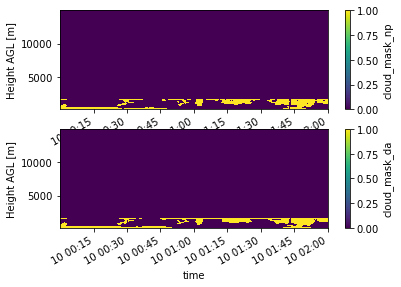

In [42]:
fig, axs = plt.subplots(2,1)
ds.cloud_mask_np.plot(x='time', ax=axs[0])
ds.cloud_mask_da.plot(x='time', ax=axs[1])

plt.show()

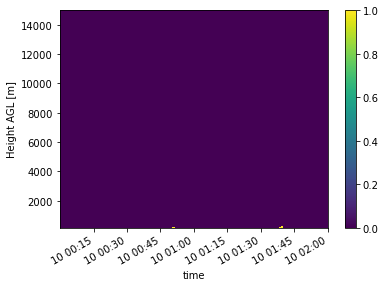

In [43]:
(ds.cloud_mask_da != ds.cloud_mask_np).plot(x='time')